# Online Retail – Customer Segmentation & Recommender System
Romeo Cozac (June, 2018)
___
**The Data**: This is a transnational dataset which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

**Goals**: Through this notebook, we aim to better understand customer behavior as well as trends in sales, and to use this information to answer business questions. We look at new customer acquisition through time and repeat purchase rates, as we want to segment customers based on how much value they are likely to bring in the future. Also, we check which products each one of our segments prefers and which ones are more troublesome. Finally, we build a collaborative filtering based recommender system.
___
**1. Setup and Prerequisites**

    1.1. Loading Data and Dependencies
    1.2. Visualizing the Data
    1.3. Data Preparation and Feature Engineering
    1.4. Empty Values
    
**2. Orders**

    2.1. Basic Stats
    2.2. Cancellations
    2.3. Countries
    2.4. Sales
    2.5. Guest Orders
    
**3. Products**

    3.1. Operational Costs
    3.2. Most sold products
    3.3. Product Description Analysis
    
**4. Customers**

    4.1. Customer Loyalty
    4.2. Important Customer Segments
    
___
## 1. Setup and Prerequisites
In this phase we prepare our environment and load everything that's needed.

### 1.1. Loading Data and Dependencies
As a first step, we download the data under from kaggle into to the `data/` directory

In [3]:
!kaggle datasets download -d carrie1/ecommerce-data -p data/

100%|██████████████████████████████████████| 7.95M/7.95M [00:01<00:00, 5.06MB/s]



Next, we load the modules and dependencies used in the notebook

In [283]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#import geopandas as gpd
import seaborn as sns
import calendar
from wordcloud import WordCloud
from scipy import stats
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import Counter

Finally, we load the data into memory

In [2]:
df = pd.read_csv('data/data.csv', encoding = "ISO-8859-1")

### 1.2. Visualizing the Data

Our dataset contains the following information:
- **InvoiceNo**: *(discrete)* `string` — A unique identifier for each purchase made. <br />
  - This variable is generally numeric. When the value starts with a "C", it indicates a cancelled item. <br />
- **StockCode**: *(discrete)* `string` — A unique identifier for the product that was purchased. <br />
  - When the fields contain only letters, it indicates a type of operation instead of a product ID (ie: discount or manual adjustment)
- **Description**: *(discrete)* `string` — Name of the purchased product. <br />
  - In case of a certain operation like discounts, this field will contain additional details as to what appears in "StockCode
- **Quantity**: *(continuous)* `int` — How many products were bought on this order. <br />
- **InvoiceDate**: *(continuous)* `date` — When the order was made. <br />
- **UnitPrice**: *(continuous)* `float` — Product price per unit (in pound sterling). <br />
  - This can be negative in case of a cancellation or discount
- **CustomerID**: *(discrete)* `int` — A unique identifier for the customer who made the order. <br />
- **Country**: *(discrete)* `string` — Location of the store.

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


We can see that our dataset is focused on *products* (order items) instead of orders as there are duplicate `InvoiceNo`s. This means that each row represents a unique product from an order made.

### 1.3. Data Preparation and Feature Engineering
We first cast the type of **InvoiceDate** to `datetime` and add a new field called **RowTotal**, which is the total amount paid on the entry.

In [3]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], infer_datetime_format=True)
df["RowTotal"] = df["Quantity"] * df["UnitPrice"]

Order based metrics (instead of order items) is also something we want to look at, so we create an aggregated DataFrame based on orders. We compute the **GrandTotal** for each order and count the number of unique products, as well as the total number of items purchased.

In [4]:
orders = df.groupby("InvoiceNo") \
    .agg({
        'StockCode':'count',
        'Quantity': 'sum',
        'RowTotal': 'sum',
        'Country': 'first',
        'InvoiceDate': 'first',
        'CustomerID': 'first'}) \
    .reset_index() \
    .rename(columns={
        'StockCode':'ProductsCount', 
        'Quantity': 'ItemsCount', 
        'RowTotal': 'GrandTotal'
    })
    
orders.head()

,InvoiceNo,ProductsCount,ItemsCount,GrandTotal,Country,InvoiceDate,CustomerID
0,536365,7,40,139.12,United Kingdom,2010-12-01 08:26:00,17850.0
1,536366,2,12,22.20,United Kingdom,2010-12-01 08:28:00,17850.0
2,536367,12,83,278.73,United Kingdom,2010-12-01 08:34:00,13047.0
3,536368,4,15,70.05,United Kingdom,2010-12-01 08:34:00,13047.0
4,536369,1,3,17.85,United Kingdom,2010-12-01 08:35:00,13047.0


### 1.4. Empty Values

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
RowTotal       541909 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 37.2+ MB


The dataset contains a little over 540,000 entries (order items). Most variables have a value 100% of the time, except for the **Description**, but especially for the **CustomerID**. It is possible the entries missing a customer ID were submitted by guests (people who placed an order without creating an account).

We take a closer look at the **Description** field.

In [12]:
no_descriptions = df[df["Description"].isnull()]
no_descriptions.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RowTotal
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom,0.0
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom,0.0
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,0.0
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,0.0
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom,0.0


Most rows that match this description are free items (**UnitPrice** is 0). We check if this is always the case, which indeed is.

In [13]:
print('There are %s entries with an empty "Description" and a non-zero "UnitPrice"' % sum(no_descriptions["UnitPrice"] > 0))

There are 0 entries with an empty "Description" and a non-zero "UnitPrice"


## 2. Orders
This section is focused on orders and sales. We cover:
- purchasing frequencies throughout the year (as well as weekdays and work hours)
- cancellations
- global distribution of orders
- the average order value
- orders placed by guests

### 2.1. Basic Stats
Knowing the smallest product price, the largest number of items purchased at once or the average sale value might be of interest. To get an accurate estimate we will exclude cancelled orders, free items, and outliers (keeping ~99.7% of the values).

In [5]:
clean_transactions = df[(df["RowTotal"] > 0) & (df["StockCode"].str.contains('\d', regex=True))]
clean_transactions = clean_transactions[["Quantity", "UnitPrice", "RowTotal"]]

clean_orders = orders[orders["GrandTotal"] > 0]
clean_orders = clean_orders[["ProductsCount", "ItemsCount", "GrandTotal"]]

clean_transactions = clean_transactions[(np.abs(stats.zscore(clean_transactions)) < 3).all(axis=1)]
clean_orders = clean_orders[(np.abs(stats.zscore(clean_orders)) < 3).all(axis=1)]

In [15]:
clean_transactions.describe()

,Quantity,UnitPrice,RowTotal
count,520539.000000,520539.000000,520539.000000
mean,9.445427,3.009416,17.153683
std,21.287281,2.737098,35.895841
min,1.000000,0.040000,0.060000
25%,1.000000,1.250000,3.750000
50%,4.000000,2.080000,9.840000
75%,12.000000,4.130000,17.400000
max,468.000000,16.130000,816.750000


Looking at *order items*:
- We are left with around 520,000 entries
- On average 9-10 items are ordered from each product. However, the median is only 4, suggesting more orders with a lower quantity and a few orders with "extreme" quantities (probably wholesalers);
- The price per unit indicates that the vendor is selling low priced items. It ranges from 4p to little over 16£, with a median close to 2£.

In [16]:
clean_orders.describe()

,ProductsCount,ItemsCount,GrandTotal
count,19478.000000,19478.000000,19478.000000
mean,21.632611,228.124191,412.976755
std,23.397583,288.844859,507.928780
min,1.000000,1.000000,0.380000
25%,6.000000,68.000000,149.685000
50%,15.000000,147.000000,301.200000
75%,28.000000,281.000000,471.165000
max,169.000000,3104.000000,5867.080000


Looking at *orders*:
- There are close to 20,000 orders in the dataset
- The order statistics, as well as the mean of the "ProductsCount" and "ItemsCount", indicates that the vendor is heavily focused on bulk sales. On average, more than 20 different products are purchased on every order with an average total item count of ~230 per order.
- The average order value is little over 400£, with 75% of the orders being ~150£ or over.

### 2.2. Cancellations
We want to know how many orders are cancelled.

In [6]:
cancelled_orders = orders[orders['InvoiceNo'].str.contains('C')]
cancelled_orders.head()

,InvoiceNo,ProductsCount,ItemsCount,GrandTotal,Country,InvoiceDate,CustomerID
22064,C536379,1,-1,-27.50,United Kingdom,2010-12-01 09:41:00,14527.0
22065,C536383,1,-1,-4.65,United Kingdom,2010-12-01 09:49:00,15311.0
22066,C536391,7,-132,-141.48,United Kingdom,2010-12-01 10:24:00,17548.0
22067,C536506,1,-6,-25.50,United Kingdom,2010-12-01 12:38:00,17897.0
22068,C536543,2,-3,-3.80,United Kingdom,2010-12-01 14:30:00,17841.0


Besides the **GrandTotal** the **ItemsCount** is also negative for cancelled orders. This could indicate that a new entry is created for cancellations instead of the old ones being overwritten. We wish to verify this theory.

In [18]:
aggregate_table = df.copy()
aggregate_table['count_per_customer'] = aggregate_table.groupby('CustomerID')['CustomerID'].transform('count')
aggregate_table['min_per_customer'] = aggregate_table.groupby('CustomerID')['RowTotal'].transform('min')

aggregate_table[
    (aggregate_table['count_per_customer'] == 2) 
    & (aggregate_table['min_per_customer'] < 0)
].sort_values(by=['CustomerID', 'StockCode', 'InvoiceDate']).loc[:, 'InvoiceNo':'CustomerID'].head(n=8)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0
31983,C539037,22474,SPACEBOY TV DINNER TRAY,-32,2010-12-15 14:42:00,4.25,12666.0
31982,C539037,84792,ENCHANTED BIRD COATHANGER 5 HOOK,-24,2010-12-15 14:42:00,3.81,12666.0
18974,C537824,22220,CAKE STAND LOVEBIRD 2 TIER WHITE,-1,2010-12-08 14:27:00,9.95,12870.0
18975,C537824,22784,LANTERN CREAM GAZEBO,-1,2010-12-08 14:27:00,4.95,12870.0
283862,561811,22456,NATURAL SLATE CHALKBOARD LARGE,18,2011-07-29 15:12:00,4.25,13106.0
288420,C562160,22456,NATURAL SLATE CHALKBOARD LARGE,-4,2011-08-03 11:50:00,4.25,13106.0


For ease, order items were filtered down to customers with only 2 row items and at least 1 negative row item. We notice several interesting cases:
- It is confirmed that indeed, new items are added in case of a cancellation instead of old rows being updated;
- Partial cancellations are possible since the quantities don't always match up;
- Not every cancellation has a matching pair (these could be cancellations of orders placed before 01/12/2010).

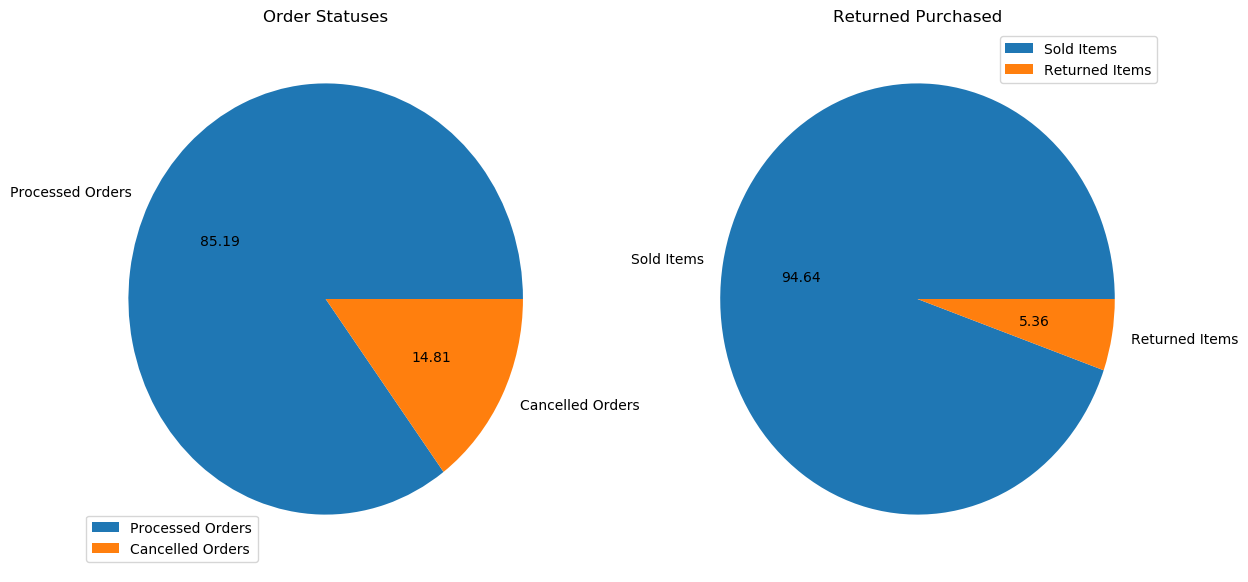

In [324]:
orders_count = pd.DataFrame({'Orders Count': [orders.shape[0] - cancelled_orders.shape[0], cancelled_orders.shape[0]]},
                             index=['Processed Orders', 'Cancelled Orders'])

total_items_count = sum(df['Quantity'])
refunded_items_count = sum(df[df['InvoiceNo'].str.contains('C')]['Quantity']) * -1
items_count = pd.DataFrame({'Items Count': [total_items_count - refunded_items_count, refunded_items_count]},
                             index=['Sold Items', 'Returned Items'])

fig, axes = plt.subplots(1, 2)
axes[0].axis('off')
axes[1].axis('off')

orders_count.plot(kind='pie', y='Orders Count', autopct='%.2f', ax=axes[0], title='Order Statuses', figsize=(14, 7))
items_count.plot(kind='pie', y='Items Count', autopct='%.2f', ax=axes[1], title='Returned Purchased', figsize=(14, 7))

Almost 15% of all orders are cancellations, but only ~5% of items are cancellend (due to partial cancellations)
### 2.3. Countries
We want to know how orders are distributed throughout the world.

In [147]:
orders_per_country = orders.groupby("Country").agg({
    'Country':'first',
    'InvoiceNo':'count'
}).rename(columns={'InvoiceNo': 'Orders'})

orders_per_country.loc['EIRE', 'Country'] = 'Ireland'
orders_per_country.loc['Czech Republic', 'Country'] = 'Czech Rep.'
orders_per_country.loc['USA', 'Country'] = 'United States'

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(orders_per_country, left_on="name", right_on="Country")

orders_count = sum(world["Orders"])
world['Percentage'] = world['Orders'] / orders_count * 100

print('Orders Distribution around the World')
world.sort_values('Orders', ascending=False)[['Country', 'Orders', 'Percentage']].head()

Orders Distribution around the World


,Country,Orders,Percentage
14,United Kingdom,23494,91.030261
9,Germany,603,2.336394
13,France,461,1.786199
16,Ireland,360,1.394862
3,Belgium,119,0.461079


A little over 91% of all orders were placed from the UK, but the next 4 biggest markets are from Europe as well. Taking a closer look, we confirm that almost all orders are placed from Europe.

In [130]:
"%.2f%% of orders were placed from Europe" % sum(world[world['continent'] == 'Europe']['Percentage'])

'99.43% of orders were placed from Europe'

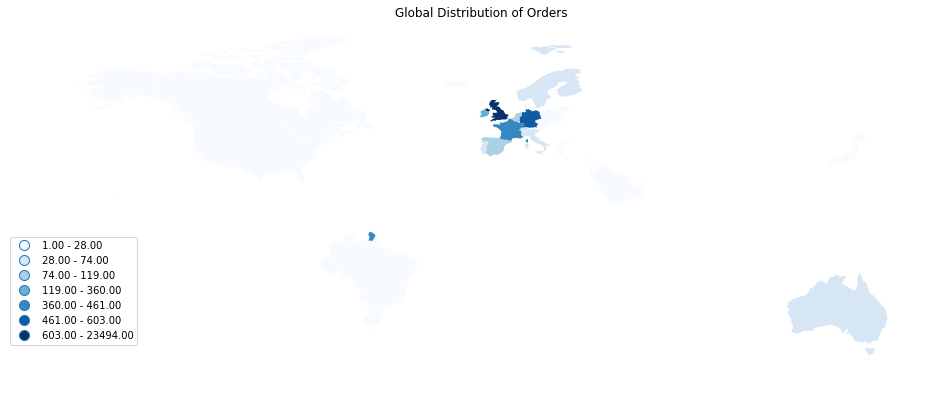

In [195]:
ax = world.plot(column='Orders', cmap='Blues', figsize=(16, 7), scheme='fisher_jenks', k=7, legend=True)

ax.set_axis_off()
ax.set_title('Global Distribution of Orders')
ax.get_legend().set_bbox_to_anchor((.12, .4))

### 2.4. Sales
We start by calculating the **Average Order Value**, followed by a look at trends in revenue.

In [322]:
pd.DataFrame({
    'Total Revenue': '%dK' % (sum(clean_orders.GrandTotal) / 1000),
    'Orders Count': '%.2fK' % (clean_orders.shape[0] / 1000),
    'Average Order Value': '%.2f' % (sum(clean_orders.GrandTotal) / clean_orders.shape[0])
}, columns=[
    'Total Revenue', 'Orders Count', 'Average Order Value'
], index=['value'])

,Total Revenue,Orders Count,Average Order Value
value,10666K,19.96K,534.40


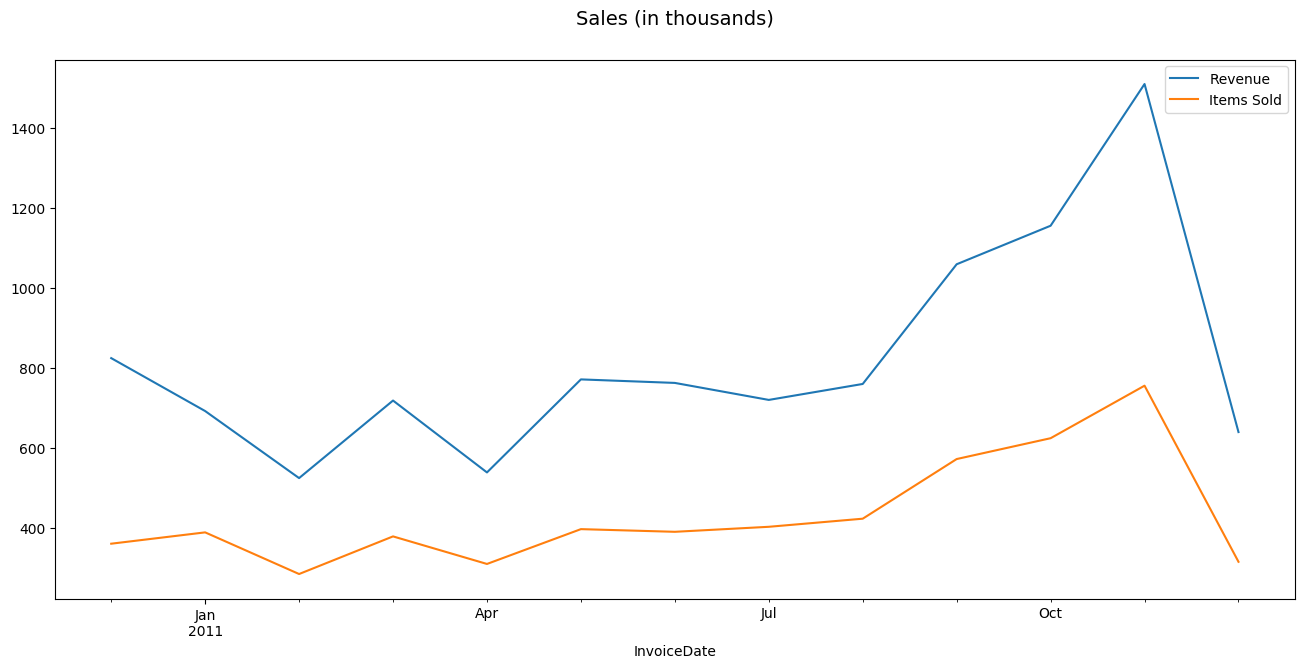

In [148]:
monthly_stats = orders[orders["GrandTotal"] > 0].groupby(pd.Grouper(key='InvoiceDate', freq='M')).agg({
    'GrandTotal': 'sum', 
    'ItemsCount': 'sum'
}).rename(columns={
    'GrandTotal': 'Revenue',
    'ItemsCount': 'Items Sold'
})

monthly_stats = monthly_stats / 1000
ax = monthly_stats.plot(kind='line', figsize=(16,7))
ax.set_title('Sales (in thousands)')
ax.title.set_position([.5, 1.05])
ax.title.set_size(14)

There is an increase in demand which starts in **August** and reaches its peak in **November**  before sales settle down once again in **December**. Sales in **November** are from 2x up to 3x higher than sales outside this high demand quarter. This increase most likely reflects customers (wholesalers) preparation for the winter holidays.

Next, we also check how cancellations are distributed in time.

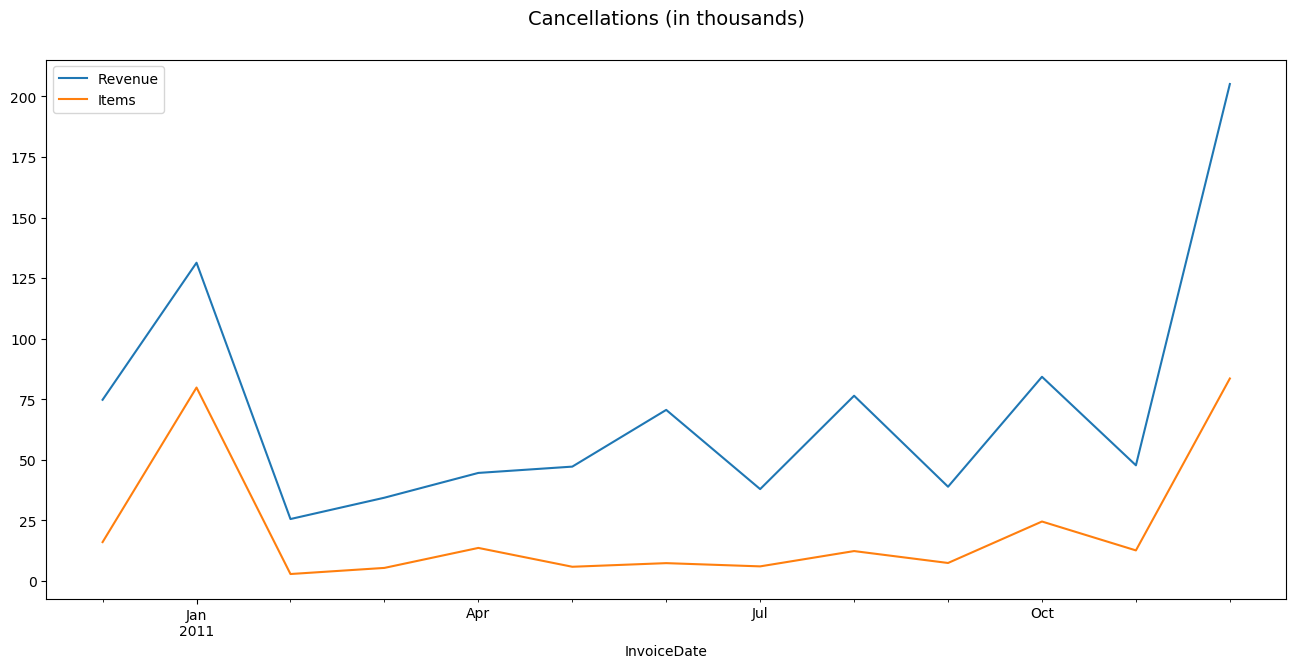

In [147]:
monthly_stats = orders[orders["GrandTotal"] < 0].groupby(pd.Grouper(key='InvoiceDate', freq='M')).agg({
    'GrandTotal': 'sum', 
    'ItemsCount': 'sum'
}).rename(columns={
    'GrandTotal': 'Revenue',
    'ItemsCount': 'Items'
})

monthly_stats = monthly_stats / 1000 * -1
ax = monthly_stats.plot(kind='line', figsize=(16,7))
ax.set_title('Cancellations (in thousands)')
ax.title.set_position([.5, 1.05])
ax.title.set_size(14)

Cancellations are fairly equally distributed throughout the year. There is an increase in **November** which could be a consequence of the increase in revenue. Another notable increase is in **January** which is not correlated with an increase in sales. One speculation is that wholesalers refunded items they don't need anymore after the winter holidays passed. This can be further investigated.

We now check the frequency of orders on each weekday.

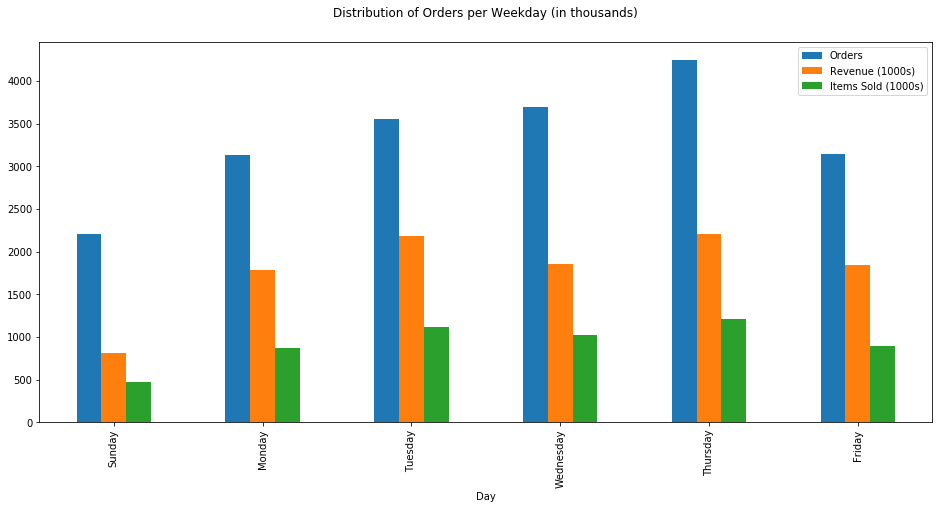

In [360]:
weekdays = orders[orders["GrandTotal"] > 0].groupby(orders.InvoiceDate.dt.strftime('%w')).agg({
    'InvoiceNo': 'count',
    'GrandTotal': 'sum', 
    'ItemsCount': 'sum'
}).rename(columns={
    'GrandTotal': 'Revenue (1000s)',
    'InvoiceNo': 'Orders',
    'ItemsCount': 'Items Sold (1000s)'
}) / 1000

weekdays.index.name = 'Day'
weekdays['Orders'] *= 1000

labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
ax = weekdays.plot(kind='bar', figsize=(16, 7))
ax.set_xticklabels(labels)
ax.set_title('Distribution of Orders per Weekday (in thousands)')
ax.title.set_position([.5, 1.05])

We can see a steady rise in orders placed throughout the week up to Thursday, when the weekly peak is reached. Then, sales drop sharply on Friday and hit the lowest point on Sunday, when sales are almost 50% less than what we noticed on Thursday. For some reason, no orders were placed on Saturday.

We further check which are the peak hours on the online store.

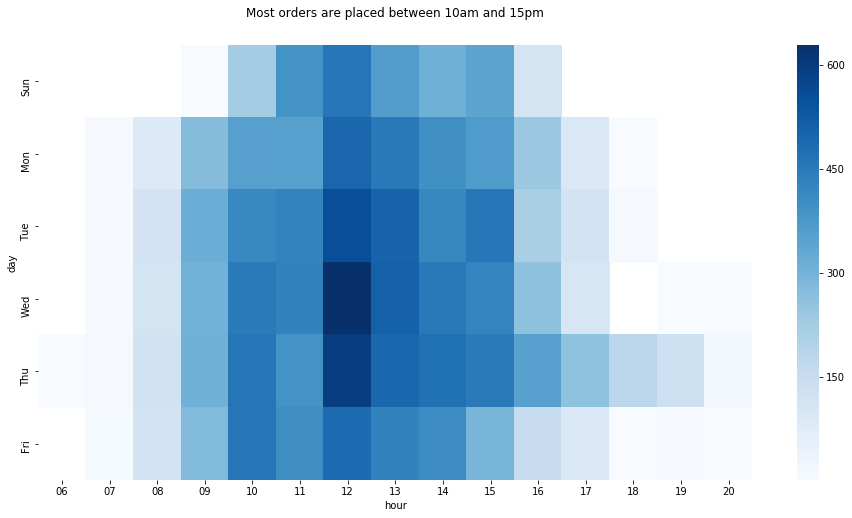

In [359]:
week_hours = orders[orders["GrandTotal"] > 0]['InvoiceNo'].groupby([
    orders.InvoiceDate.dt.strftime('%w'), 
    orders.InvoiceDate.dt.strftime('%H')
]).count()

week_hours.index.names = ['day','hour']
week_hours = week_hours.reset_index().pivot_table(index='day', columns='hour', values='InvoiceNo')

plt.figure(figsize=(16,8))
ax = sns.heatmap(week_hours, cmap='Blues')

labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri']
ax.set_yticklabels(labels)
ax.set_title('Most orders are placed between 10am and 15pm')
ax.title.set_position([.5, 1.05])

The most active hours are between 10am and 3pm, with a clear peak at noon. The busiest hours were Wednesday noon, followed by Thursday and Tuesday noon. However, order rates were higher in general on Thursday. There are virtually no orders placed between 8pm and 6am.

### 2.5. Guest Orders
We previously saw that some orders don't have a `CustomerID` and were likely placed by guests (customers with no accounts on the store). Now, we check how these orders are distributed.

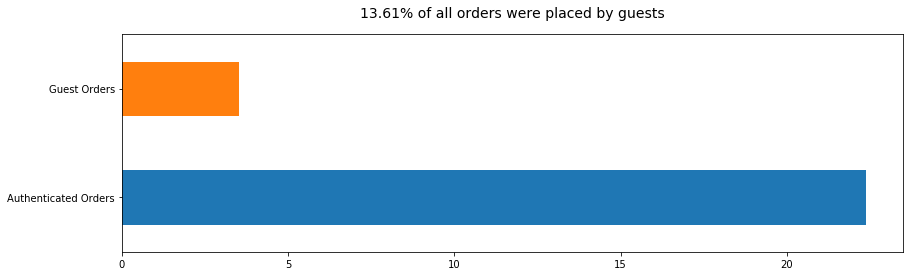

In [8]:
guest_orders_count = orders[(orders.CustomerID.isnull()) & (orders.GrandTotal >= 0)].shape[0]
order_types = pd.DataFrame({'Orders': [(orders.shape[0] - guest_orders_count) / 1000, guest_orders_count / 1000]}, 
                           index=['Authenticated Orders', 'Guest Orders'])

title = "%.2f%% of all orders were placed by guests" % (guest_orders_count / orders.shape[0] * 100)
ax = order_types.plot(kind='barh', stacked=True, y='Orders', title=title, figsize=(14, 4), legend=False)
ax.title.set_position([.5, 1.05])
ax.title.set_size(14)

Roughly 1 in 7 orders are placed by customers without an account. Furthermore, we can see below that 2 from the top 5 sales were placed by guests, thus bigger orders don't necessarily require an account.

In [161]:
orders.sort_values(by="GrandTotal", ascending=False).head()

,InvoiceNo,ProductsCount,ItemsCount,GrandTotal,Country,InvoiceDate,CustomerID
22025,581483,1,80995,168469.60,United Kingdom,2011-12-09 09:15:00,16446.0
2303,541431,1,74215,77183.60,United Kingdom,2011-01-18 10:01:00,12346.0
18776,574941,101,14149,52940.94,United Kingdom,2011-11-07 17:42:00,NaN
19468,576365,99,13956,50653.91,United Kingdom,2011-11-14 17:55:00,NaN
9741,556444,1,60,38970.00,United Kingdom,2011-06-10 15:28:00,15098.0


A high number of guest orders in a short period might indicate a fault on the store. We take a look at how guest orders are distributed throughout the year but don't see anything out of the ordinary.

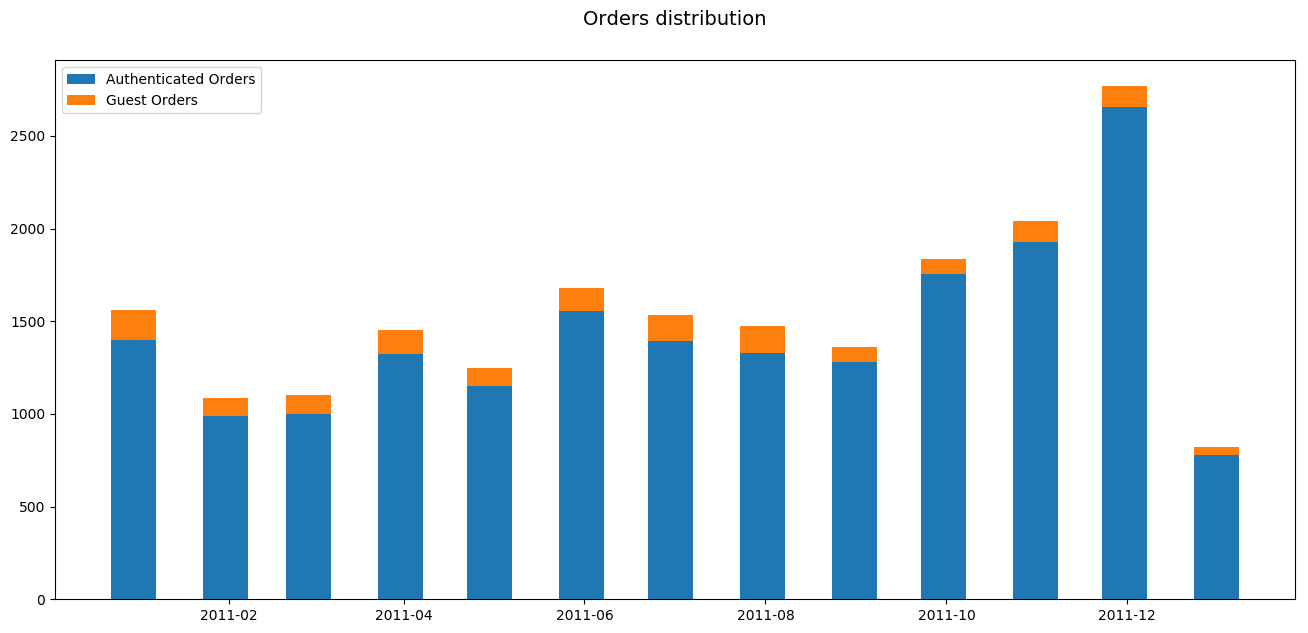

In [264]:
authenticated_orders = orders[(orders.CustomerID.notnull()) & (orders.GrandTotal > 0)] \
    .groupby(pd.Grouper(key='InvoiceDate', freq='M'))['InvoiceNo'].count()
    
guest_orders = orders[(orders.CustomerID.isnull()) & (orders.GrandTotal > 0)] \
    .groupby(pd.Grouper(key='InvoiceDate', freq='M'))['InvoiceNo'].count()

fig, ax = plt.subplots(figsize=(16,7))
plt.bar(authenticated_orders.index, authenticated_orders, width=15)
plt.bar(guest_orders.index, guest_orders, bottom=authenticated_orders, width=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_title('Orders distribution')
ax.title.set_position([.5, 1.05])
ax.title.set_size(14)
plt.legend(('Authenticated Orders', 'Guest Orders'), fancybox=True)


We also notice some strange orders with a 0 grand total, almost all of which have been placed by guests. This could be orders completed offline.

## 3. Products Insight
In this section we will:
- look at top selling products
- check the most popular product types
- split our products into categories

### 3.1. Operational costs
Among products, we notice several transactional and operational entries like bank charges, manual adjustments, and Amazon fees. These won't be useful in our case, but we want to be aware of them.

In [68]:
products = df[df.RowTotal > 0].groupby('StockCode').agg({
    'Description': 'first',
    'UnitPrice': 'first',
    'Quantity': 'sum',
    'RowTotal': 'sum',
    'InvoiceNo': 'count'
}).reset_index().rename(columns={
    'Quantity': 'ItemsSold',
    'InvoiceNo': 'Orders',
    'RowTotal': 'Sales',
})

ops = products[products.StockCode.str.contains('^(?!gift|DCG)[a-zA-Z]', regex=True)][[
    'StockCode','Description','ItemsSold','Orders'
]]
    
products = products[~products.isin(ops)].dropna()
ops

,StockCode,Description,ItemsSold,Orders
3900,AMAZONFEE,AMAZON FEE,2,2
3901,B,Adjust bad debt,1,1
3902,BANK CHARGES,Bank Charges,12,12
3903,C2,CARRIAGE,142,141
3911,DOT,DOTCOM POSTAGE,706,706
3912,M,Manual,7224,321
3913,PADS,PADS TO MATCH ALL CUSHIONS,3,3
3914,POST,POSTAGE,3150,1126
3915,S,SAMPLES,2,2
3921,m,Manual,1,1


### 3.2. Most sold products
We are now ready to check the most sold products in terms of sales, items and orders placed. Unsurprisingly, some of the products appear in all 3 rankings.

In [76]:
print('Top 5 most sold products in terms of "Sales"')
products.sort_values(by='Sales', ascending=False)[['StockCode', 'Description', 'Sales']].head()

Top 5 most sold products in terms of "Sales"


,StockCode,Description,Sales
1310,22423,REGENCY CAKESTAND 3 TIER,174484.74
2465,23843,"PAPER CRAFT , LITTLE BIRDIE",168469.60
3407,85123A,WHITE HANGING HEART T-LIGHT HOLDER,104518.80
2670,47566,PARTY BUNTING,99504.33
3387,85099B,JUMBO BAG RED RETROSPOT,94340.05


In [77]:
print('Top 5 most sold products in terms of "Items Sold"')
products.sort_values(by='ItemsSold', ascending=False)[['StockCode', 'Description', 'ItemsSold']].head()

Top 5 most sold products in terms of "Items Sold"


,StockCode,Description,ItemsSold
2465,23843,"PAPER CRAFT , LITTLE BIRDIE",80995.0
2020,23166,MEDIUM CERAMIC TOP STORAGE JAR,78033.0
1109,22197,SMALL POPCORN HOLDER,56921.0
2909,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,55047.0
3387,85099B,JUMBO BAG RED RETROSPOT,48474.0


In [78]:
print('Top 5 most sold products in terms of "Orders"')
products.sort_values(by='Orders', ascending=False)[['StockCode', 'Description', 'Orders']].head()

Top 5 most sold products in terms of "Orders"


,StockCode,Description,Orders
3407,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2265.0
3387,85099B,JUMBO BAG RED RETROSPOT,2112.0
1310,22423,REGENCY CAKESTAND 3 TIER,2017.0
2670,47566,PARTY BUNTING,1706.0
175,20725,LUNCH BAG RED RETROSPOT,1595.0


### 3.3. Product Description Analysis
To get an insight into which products are more popular, we will count the word occurrence in all product descriptions. Stop words such as "of", "to" or "and" will be excluded. Additionally, color names and words related to size are excluded, since they appear quite frequently in configurable products (products with multiple options).

(-0.5, 1599.5, 699.5, -0.5)

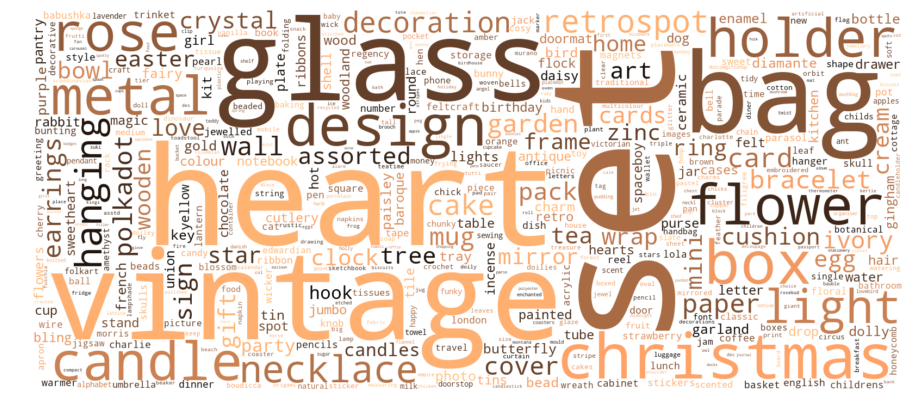

In [189]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english') + ['pink', 'blue', 'red', 'white', 'black', 'green', 'silver', 'small', 'large']

tokens = products.Description.str.lower().apply(tokenizer.tokenize).tolist()
tokens = np.hstack(tokens)
tokens = [x for x in tokens if (not x in stop_words) and (len(x) > 2)]
tokens = Counter(tokens)
labels, values = zip(*tokens.items())

word_count = pd.DataFrame({'label': labels, 'value': values}).sort_values('value', ascending=False).reset_index(drop=True)
word_count = word_count[word_count.value > 5]

word_cloud = WordCloud(background_color='white', max_words=500, width=1600, height=700, colormap='copper')
word_cloud.generate_from_frequencies(tokens)

plt.figure(figsize=(16,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

One particalar word stands out. "Christmas" is in the top 10 most frequent words in product descriptions. This is further evidence that the winter holidays have a role in the November increase in sales.

## 4. Customers

In this section we cover:
- a ranking of the most loyal customers
- customer loyalty and repeat purchase rates
- important customer segments

We start by taking a look how often customers purchase from the store. Guest orders are irrelevant for this purpose so we exclude for now.

In [362]:
free_orders = orders[orders.GrandTotal == 0].shape[0]
free_guest_orders = orders[(orders.GrandTotal == 0) & (orders.CustomerID.isnull())].shape[0]
free_orders_percent = free_orders / orders.shape[0] * 100
print("%d (that is %.2f%%) of all orders have a grand total of £0.00. Out of these %d have been placed by 'Guests'" 
      % (free_orders, free_orders_percent, free_guest_orders))

2102 (that is 8.12%) of all orders have a grand total of £0.00. Out of these 2098 have been placed by 'Guests'


### 4.1. Customer Loyalty
First we check who our most loyal customers are, then calculate the repeat purchase rate

In [427]:
orders['PreviousOrder'] = orders[orders.CustomerID.notnull()].sort_values('InvoiceDate') \
    .groupby(['CustomerID'])['InvoiceDate'].shift()
    
orders['PreviousOrder'] = orders['InvoiceDate'] - orders['PreviousOrder']
orders['PreviousOrder'] = orders['PreviousOrder'].apply(lambda x: x.days)
orders['TimeSinceLastOrder'] = (max(orders.InvoiceDate) - orders.InvoiceDate).apply(lambda x: x.days)

customers = orders[orders.CustomerID.notnull()].sort_values('InvoiceDate').groupby('CustomerID').agg({
    'GrandTotal': 'sum',
    'ItemsCount': 'sum',
    'ProductsCount': 'sum',
    'InvoiceNo': 'count',
    'PreviousOrder': 'mean',
    'TimeSinceLastOrder': 'last'
}).reset_index().rename(columns={
    'GrandTotal': 'Revenue',
    'ItemsCount': 'Items',
    'ProductsCount': 'Products',
    'InvoiceNo': 'Orders',
    'PreviousOrder': 'AverageOrderInterval'
})

print('Top 5 customers in terms of "Revenue"')
display(customers.sort_values(by='Revenue', ascending=False)[['CustomerID', 'Revenue']].head())

print('Top 5 customers in terms of "Orders"')
display(customers.sort_values(by='Orders', ascending=False)[['CustomerID', 'Orders']].head())

Top 5 customers in terms of "Revenue"


,CustomerID,Revenue
1703,14646.0,279489.02
4233,18102.0,256438.49
3758,17450.0,187482.17
1895,14911.0,132572.62
55,12415.0,123725.45


Top 5 customers in terms of "Orders"


,CustomerID,Orders
1895,14911.0,248
330,12748.0,224
4042,17841.0,169
1674,14606.0,128
568,13089.0,118


The **Repeat Purchase Rate** is an important metric when it comes to loyalty and customer retention. It represents the percentage of users who shopped more than once on our store.

In [415]:
repeat_purchase_rate = customers[customers.Orders > 1].shape[0] / customers.shape[0]
average_orders = sum(customers.Orders) / customers.shape[0]

pd.DataFrame([{
    'Customers Count': customers.shape[0],
    'Repeat Purchasers Count': customers[customers.Orders > 1].shape[0],
    'Repeat Purchase Rate': '%.4f%%' % repeat_purchase_rate,
    'Average Orders per Customer': '%.2f' % average_orders,
    'Median Orders per Customer': '%d' % customers.Orders.median()
}], columns=[
    'Customers Count', 'Repeat Purchasers Count', 'Repeat Purchase Rate', 'Average Orders per Customer', 'Median Orders per Customer'
], index=['value'])

,Customers Count,Repeat Purchasers Count,Repeat Purchase Rate,Average Orders per Customer,Median Orders per Customer
value,4372,3059,0.6997%,5.08,3


We see a very high repeat purchase rate of almost **70%**, customers placing **5** orders on average. This is a sign of a loyal customer base.

### 4.2. Important Customer Segments
We already covered a few segments such as **Top Purchasers** and **Frequent Buyers** in 4.1 or **Guest Shoppers** in 2.5. In this section we dive a little deeper and point out some other important segments such as:
- One-timers
- Active Repeat Customers
- At-Risk Customers 
- Inactive Repeat Customers 
- Thrifty Shoppers
- Coupon Lovers

#### 4.2.1 One-timers vs Repeat Purchasers
**One-timers** (or **First-Time Buyers**) are customers who placed only 1 purchase on the store. In this section, **Repeat Purchasers** will be customers with 2 or more orders.

Text(0,0.5,'')

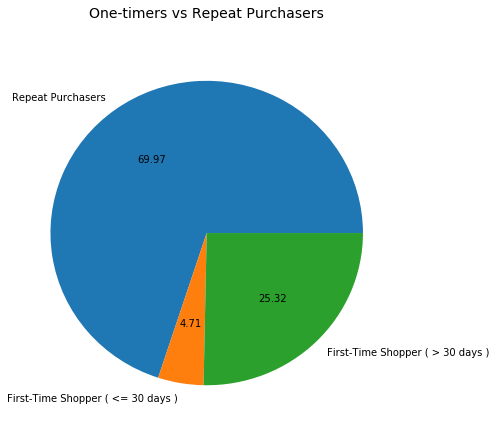

In [456]:
orders_count = pd.DataFrame({'Orders': [
    customers[customers.Orders > 1].shape[0],
    customers[(customers.Orders == 1) & (customers.TimeSinceLastOrder <= 30)].shape[0],
    customers[(customers.Orders == 1)  & (customers.TimeSinceLastOrder > 30)].shape[0]
]}, index=[
    'Repeat Purchasers', 'First-Time Shopper ( <= 30 days )', 'First-Time Shopper ( > 30 days )'
])

ax = orders_count.plot(kind='pie', y='Orders', autopct='%.2f', figsize=(7, 7), legend=False)
ax.set_title('One-timers vs Repeat Purchasers')
ax.title.set_position([.5, 1.05])
ax.title.set_size(14)
ax.set_ylabel('')

Around a quarter of all customers don't return for another purchase. We note that ~5% of our customer base made their first purchase less than 30 days ago, so we consider them as a separate segment.

#### 4.2.2. Active Repeat Customers
Active repeat customers are people who regularly shop at the store. We calculate the average number of days between orders and create our segment groups based on it.

In [464]:
average_order_interval = sum(customers[customers.AverageOrderInterval.notnull()]["AverageOrderInterval"]) \
                            / customers[customers.AverageOrderInterval.notnull()].shape[0]
                             
"The average order interval is: %d days" % average_order_interval

'The average order interval is: 60 days'

Text(0,0.5,'')

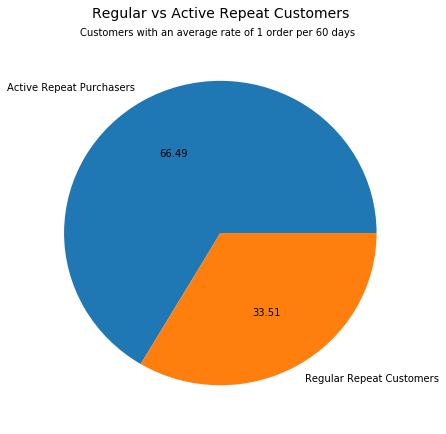

In [499]:
orders_count = pd.DataFrame({'Orders': [
    customers[(customers.Orders > 1) & (customers.AverageOrderInterval <= average_order_interval)].shape[0],
    customers[(customers.Orders > 1) & (customers.AverageOrderInterval > average_order_interval)].shape[0]
]}, index=[
    'Active Repeat Purchasers', 'Regular Repeat Customers'
])

ax = orders_count.plot(kind='pie', y='Orders', autopct='%.2f', figsize=(7, 7), legend=False)
ax.set_title('Regular vs Active Repeat Customers')
ax.text(-0.9, 1.3, 'Customers with an average rate of 1 order per %d days' % average_order_interval, fontsize=10)
ax.title.set_position([.5, 1.05])
ax.title.set_size(14)
ax.set_ylabel('')

#### 4.2.3. Customers at Risk
Active Repeat Purchasers are true advocates of a brand and one of the most important segments for any store. If members of this group take a suspiciously long time to make an order, we need to know. A customer will be considered "at risk" if their last order happened more than 60 days ago (which is our average order interval)

Text(0,0.5,'')

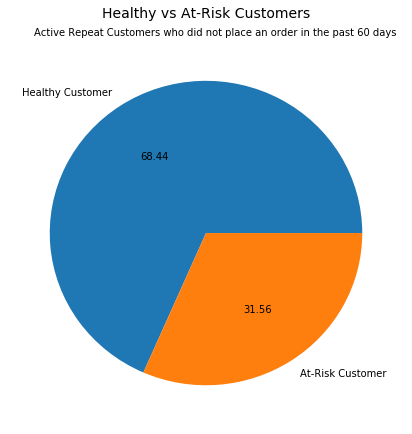

In [500]:
orders_count = pd.DataFrame({'Orders': [
    customers[
        (customers.Orders > 1) 
        & (customers.AverageOrderInterval <= average_order_interval) 
        & (customers.TimeSinceLastOrder <= average_order_interval)
    ].shape[0],
    customers[
        (customers.Orders > 1) 
        & (customers.AverageOrderInterval <= average_order_interval) 
        & (customers.TimeSinceLastOrder > average_order_interval)
    ].shape[0]
]}, index=[
    'Healthy Customer', 'At-Risk Customer'
])

ax = orders_count.plot(kind='pie', y='Orders', autopct='%.2f', figsize=(7, 7), legend=False)
ax.set_title('Healthy vs At-Risk Customers')
ax.text(-1.10, 1.3, 'Active Repeat Customers who did not place an order in the past %d days' % average_order_interval, fontsize=10)
ax.title.set_position([.5, 1.05])
ax.title.set_size(14)
ax.set_ylabel('')

#### 4.2.4. Inactive Repeat Purchasers
Finally, we take a look at our inactive (or churned) customers. A customer becomes inactive when 3 times the average order interval passed since their last order. This in our case is 180 days.

Text(0,0.5,'')

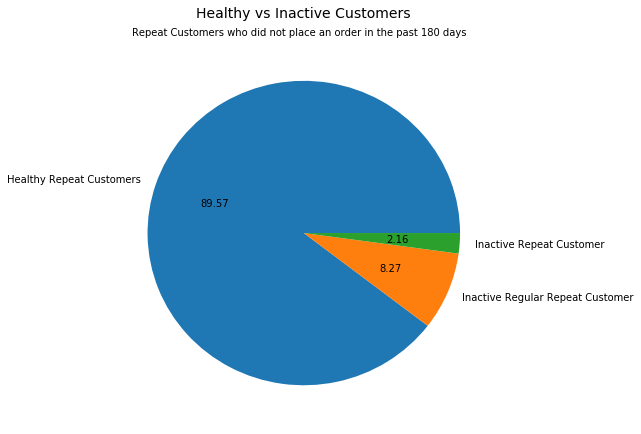

In [505]:
orders_count = pd.DataFrame({'Orders': [
    customers[(customers.Orders > 1) & (customers.TimeSinceLastOrder <= 3 * average_order_interval)].shape[0],
    customers[
        (customers.Orders > 1)
        & (customers.TimeSinceLastOrder > 3 *average_order_interval)
        & (customers.AverageOrderInterval <= average_order_interval) 
    ].shape[0],
    customers[
        (customers.Orders > 1)
        & (customers.TimeSinceLastOrder > 3 *average_order_interval)
        & (customers.AverageOrderInterval > average_order_interval) 
    ].shape[0]
]}, index=[
    'Healthy Repeat Customers', 'Inactive Regular Repeat Customer', 'Inactive Repeat Customer'
])

ax = orders_count.plot(kind='pie', y='Orders', autopct='%.2f', figsize=(7, 7), legend=False)
ax.set_title('Healthy vs Inactive Customers')
ax.text(-1.1, 1.3, 'Repeat Customers who did not place an order in the past %d days' % (3 * average_order_interval), fontsize=10)
ax.title.set_position([.5, 1.05])
ax.title.set_size(14)
ax.set_ylabel('')

#### 4.2.5. Thrifty Shoppers
We know that the store has a very high repeat purchase rate, but how many orders are actually many? Next, we take a look at the average orders count and create subgroups according to it.

In [507]:
average_order_count = sum(customers.Orders) / customers.shape[0]
"The average order count per customer is: %d" % average_order_count

'The average order count per customer is: 5'

Text(0,0.5,'')

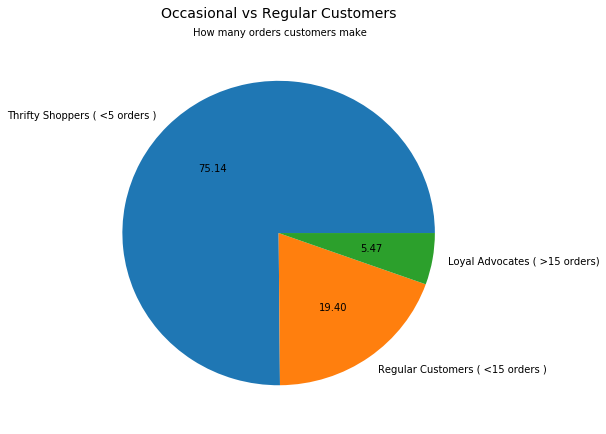

In [513]:
orders_count = pd.DataFrame({'Orders': [
    customers[customers.Orders <= average_order_count].shape[0],
    customers[(customers.Orders > average_order_count) & (customers.Orders <= 3 * average_order_count)].shape[0],
    customers[customers.Orders > 3 * average_order_count].shape[0],
]}, index=[
    'Thrifty Shoppers ( <5 orders )', 'Regular Customers ( <15 orders )', 'Loyal Advocates ( >15 orders)'
])

ax = orders_count.plot(kind='pie', y='Orders', autopct='%.2f', figsize=(7, 7), legend=False)
ax.set_title('Occasional vs Regular Customers')
ax.text(-0.55, 1.3, 'How many orders customers make', fontsize=10)
ax.title.set_position([.5, 1.05])
ax.title.set_size(14)
ax.set_ylabel('')

#### 4.2.6. Coupon Lovers
There is a custom transaction for discounts. We now take a closer look at it.

In [523]:
orders_with_discounts = len(df[df['StockCode'] == 'D']['InvoiceNo'].unique())
'Out of %d orders, %d have a discount' % (orders.shape[0], orders_with_discounts)

'Out of 25900 orders, 65 have a discount'

There are too few discounted orders to proceed any further. Given the data at hand, customers seldom use coupons or any other discounts for that matter.